In [64]:
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import torch.onnx
from sklearn.model_selection import train_test_split

In [65]:
input_img_sz=11
layer0_output_size =16

In [66]:
%matplotlib inline
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="../data",    
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(input_img_sz), torchvision.transforms.ToTensor()]
    ),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(input_img_sz), torchvision.transforms.ToTensor()]
    ),
)

In [67]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.liner0 = nn.Linear(input_img_sz*input_img_sz, layer0_output_size)
        self.relu = nn.ReLU(inplace=True)
        self.liner1 =nn.Linear(layer0_output_size, 10)


    def forward(self, x):
        x = self.flatten(x)
        x = self.liner0(x)
        x = self.relu(x)
        x = self.liner1(x)
        return x

model = NeuralNetwork().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (liner0): Linear(in_features=121, out_features=16, bias=True)
  (relu): ReLU(inplace=True)
  (liner1): Linear(in_features=16, out_features=10, bias=True)
)
Shape of X [N, C, H, W]: torch.Size([64, 1, 11, 11])
Shape of y: torch.Size([64]) torch.int64


In [68]:
def myplot(x_data,ydata,name):
    import matplotlib.pyplot as plt
    plt.plot(x_data,ydata)
    plt.title("Learning Curve "+name,fontsize=18)
    plt.xlabel("Epoch",fontsize=30)
    plt.xticks(fontsize=20)
    plt.ylabel("Accuracy(%)",fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()
    fig = plt.gcf()
    fig.set_size_inches(12,10)
    fig.savefig('./Learning_curve_png/'+name, dpi=100)

In [69]:
import os
acc_line = []
file_name ="1MNIST"+str(input_img_sz)+"x"+str(input_img_sz)+"_"+str(layer0_output_size)+"_10.pth"
if not (os.path.isfile(file_name)):
    epochs = 50
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        acc_result=test(test_dataloader, model, loss_fn)
        acc_line.append(acc_result)
        # torch.save(model, file_name)
    print("Done!")

else:
    #model.load_state_dict(torch.load("model.pth"))
    model = torch.load( file_name)
    print("Model loaded")

Epoch 1
-------------------------------
loss: 2.323524  [    0/60000]
loss: 1.926659  [ 6400/60000]
loss: 1.461270  [12800/60000]
loss: 0.959743  [19200/60000]
loss: 0.802869  [25600/60000]
loss: 0.678762  [32000/60000]
loss: 0.502430  [38400/60000]
loss: 0.681568  [44800/60000]
loss: 0.589091  [51200/60000]
loss: 0.542241  [57600/60000]
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.468602 

Epoch 2
-------------------------------
loss: 0.518869  [    0/60000]
loss: 0.429030  [ 6400/60000]
loss: 0.400153  [12800/60000]
loss: 0.445035  [19200/60000]
loss: 0.401973  [25600/60000]
loss: 0.414819  [32000/60000]
loss: 0.272269  [38400/60000]
loss: 0.463455  [44800/60000]
loss: 0.399035  [51200/60000]
loss: 0.438740  [57600/60000]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.352857 

Epoch 3
-------------------------------
loss: 0.350658  [    0/60000]
loss: 0.345944  [ 6400/60000]
loss: 0.302196  [12800/60000]
loss: 0.393148  [19200/60000]
loss: 0.321957  [25600/60000]
loss: 0.369006  [32000/600

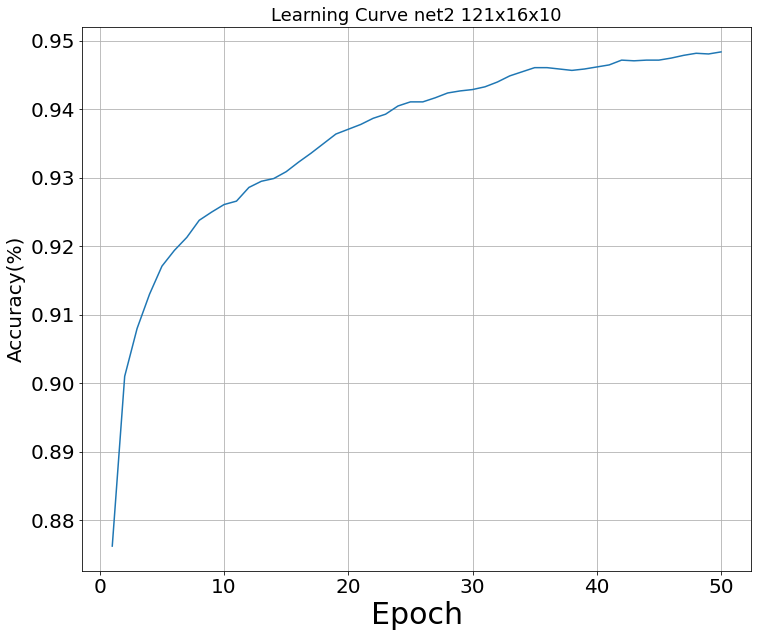

In [70]:
myplot(np.arange(1,epochs+1),acc_line,"net2 121x16x10")

In [42]:
model = torch.load( file_name)
for ele in model.state_dict():#turn to numpy
    model.state_dict()[ele]=model.state_dict()[ele].cpu().numpy()
#turn float to int
for layers in model.state_dict():
    try:
        model.state_dict()[layers].shape[1]## if parameter is 2D
        row,col=model.state_dict()[layers].shape
        for row in range(model.state_dict()[layers].shape[0]):
            for col in range(model.state_dict()[layers].shape[1]):
                num=int((model.state_dict()[layers][row][col]+1)/2*255-127)
                model.state_dict()[layers][row][col]= num
    except:
        #model[layers].shape #1D
        # print(model[layers].shape[0])
        for i in range(model.state_dict()[layers].shape[0]):
            num=int((model.state_dict()[layers][i]+1)/2*255-127)
            model.state_dict()[layers][i]=num
test(test_dataloader, model, loss_fn)
model.state_dict()

Test Error: 
 Accuracy: 94.6%, Avg loss: 1621.702323 



OrderedDict([('liner0.weight',
              tensor([[ 19.,  33., -23.,  ...,   0.,   8., -15.],
                      [-21.,  27.,  73.,  ..., -18.,  31.,  57.],
                      [ 18.,  13.,  60.,  ...,  55., -14.,  14.],
                      ...,
                      [-25., -56., -60.,  ..., -24., -12., -24.],
                      [ -9., -35., -55.,  ...,  62., 113.,  25.],
                      [-51., -50., -80.,  ...,  46., -10., -26.]], device='cuda:0')),
             ('liner0.bias',
              tensor([-26.,  45., -11.,  34.,  58.,  36.,  29.,  20.,  55.,  33., -25.,  -1.,
                       34.,  13.,  39.,  33.,  -9.,  18.,  11.,   1.,  30.,   8.,  45.,  -5.,
                      -33., -28., -15.,   6.,  -9.,  50.,  77., -19.], device='cuda:0')),
             ('liner1.weight',
              tensor([[  62.,    3.,   62.,   54.,   28., -140., -104.,  -81.,  -66.,  -24.,
                        -96.,   77.,  -66., -161., -130.,   86.,  -22.,  -56.,  -11.,   -1.,
  

In [43]:
model = torch.load( file_name)
A=59
for ele in model.state_dict():#turn to numpy
    model.state_dict()[ele]=model.state_dict()[ele].cpu().numpy()
#turn float to int
for layers in model.state_dict():
    try:
        model.state_dict()[layers].shape[1]## if parameter is 2D
        row,col=model.state_dict()[layers].shape
        for row in range(model.state_dict()[layers].shape[0]):
            for col in range(model.state_dict()[layers].shape[1]):
                num=int((model.state_dict()[layers][row][col]+1)/2*255-127)
                model.state_dict()[layers][row][col]= round(num/A)*A
    except:
        #model[layers].shape #1D
        # print(model[layers].shape[0])
        for i in range(model.state_dict()[layers].shape[0]):
            num=int((model.state_dict()[layers][i]+1)/2*255-127)
            model.state_dict()[layers][i]=round(num/A)*A
test(test_dataloader, model, loss_fn)
model.state_dict()

Test Error: 
 Accuracy: 89.6%, Avg loss: 3117.486193 



OrderedDict([('liner0.weight',
              tensor([[  0.,  59.,   0.,  ...,   0.,   0.,   0.],
                      [  0.,   0.,  59.,  ...,   0.,  59.,  59.],
                      [  0.,   0.,  59.,  ...,  59.,   0.,   0.],
                      ...,
                      [  0., -59., -59.,  ...,   0.,   0.,   0.],
                      [  0., -59., -59.,  ...,  59., 118.,   0.],
                      [-59., -59., -59.,  ...,  59.,   0.,   0.]], device='cuda:0')),
             ('liner0.bias',
              tensor([  0.,  59.,   0.,  59.,  59.,  59.,   0.,   0.,  59.,  59.,   0.,   0.,
                       59.,   0.,  59.,  59.,   0.,   0.,   0.,   0.,  59.,   0.,  59.,   0.,
                      -59.,   0.,   0.,   0.,   0.,  59.,  59.,   0.], device='cuda:0')),
             ('liner1.weight',
              tensor([[  59.,    0.,   59.,   59.,    0., -118., -118.,  -59.,  -59.,    0.,
                       -118.,   59.,  -59., -177., -118.,   59.,    0.,  -59.,    0.,    0.,
  

In [44]:
#turn img from float to int
def int_conver(np_a):
    for idx,ele in enumerate(np_a):
        np_a[idx]=int((ele+1)/2*255-127)

    return np_a

In [45]:
hit=0
lrsb0_len=layer0_output_size
lrsb2_len=10
max_0,min_0=0,0
max_1,min_1=0,0

lrsw0=model.state_dict()["liner0.weight"].reshape(-1).cpu().numpy()
lrsb0=model.state_dict()["liner0.bias"].reshape(-1).cpu().numpy()
lrsw2=model.state_dict()["liner1.weight"].reshape(-1).cpu().numpy()
lrsb2=model.state_dict()["liner1.bias"].reshape(-1).cpu().numpy()
for r in range(1):    
    img,label=test_data[r]
    img=img.reshape(-1)
    img=int_conver(img)

    out1=np.zeros(lrsb0_len)
    out2=np.zeros(lrsb2_len)
    
    for i in range(lrsb0_len):
        for j in range(input_img_sz*input_img_sz):
            out1[i]+=lrsw0[i*input_img_sz*input_img_sz+j]*img[j]
        out1[i]+=lrsb0[i]
    # print(out1)

    for i in range(lrsb0_len):
        if(out1[i]>max_0):
            max_0=out1[i]
        if(out1[i]<min_0):
            min_0=out1[i]
        if(out1[i]<0):
            out1[i]=0

    for i in range(lrsb2_len):
        for j in range(lrsb0_len):
            out2[i]+=lrsw2[i*lrsb0_len+j]*out1[j]
        out2[i]+=lrsb2[i]

    for i in range(10):
        if(out2[i]>max_1):
            max_1=out2[i]
        if(out2[i]<min_1):
            min_1=out2[i]
    print(out2)
    if(out2.argmax()==label):
        hit+=1

    # print("now:",r+1,"hit:",hit)
print(hit)
layer0_bit = len(bin(int(max_0)))
layer2_bit = len(bin(int(max_1)))+2
print("0: ",layer0_bit)
print("1: ",layer2_bit)

[ -9771167. -32453304.   -549998.  13854380. -26145791.  -6363209.
 -34273926.  16454746.  -2461126.   2607269.]
1
0:  18
1:  28


In [46]:
import TCB
def D2reg(num,reg_name):
    if(num==0):
        return None
    else:
        tcb_str=TCB.Bin2TCB(int(num))
        temp=0
        if(num>0):
            out_s="+(0"
        else:
            out_s="-(0"
        for s in reversed(tcb_str):
            if(s=="+"):
                out_s+="+("+reg_name+"<<"+str(temp)+")"
            if(s=="-"):
                out_s+="-("+reg_name+"<<"+str(temp)+")"
            temp+=1         
            
        return out_s+")"
D2reg(-29,"reg")        


'-(0+(reg<<0)-(reg<<2)+(reg<<5))'

In [47]:

img_size=input_img_sz*input_img_sz
wire_cnt=layer0_output_size
in_buffer_weight_name="in_buffer_weight"
weight_to_bias_name="weight_bias"
bias_relu_name="bias_relu"
in_buffer_weight_parameter=model.state_dict()["liner0.weight"]
weight_bias_parameter=model.state_dict()["liner0.bias"]
#data_bit_num=20
data_bit_num=layer0_bit
file_destination = "verilog_net0"

layer0_verilog_file_name="layer0_tcb_"+str(img_size)+"x"+str(layer0_output_size)+"x10"
f=open("./"+file_destination+"/"+layer0_verilog_file_name+".v","w")
f.write("module "+layer0_verilog_file_name+"\n")
f.write("(\n")

f.write("\
    input clk,\n\
    input rst,\n\
    input ["+str(img_size)+"*8-1:0] img,\n\
    input valid,\n\
    output  reg ready,\n\
    output ["+str(data_bit_num)+"*"+str(layer0_output_size)+"-1:0] layer_out\n"\
)
f.write(");\n")
f.write("parameter DATA_WIDTH = "+str(data_bit_num)+";\n")
f.write("parameter IMG_SZ   =   "+str(img_size)+";\n")

f.write("reg    signed [8-1:0]  in_buffer[0:IMG_SZ-1];\n")
f.write("integer i;\n")
f.write("always@(posedge clk )\n\
    begin\n\
        if(rst)\n\
            begin\n\
                for(i=0;i<IMG_SZ;i=i+1)\n\
                    begin\n\
                        in_buffer[i]<=0;\n\
                    end\n\
            end\n\
        else\n\
        begin\n")

for i in range(img_size):
    f.write("       in_buffer["+str(i)+"]<=img["+str(7+i*8)+":"+str(0+i*8)+"];\n")           
f.write("        end\n   end\n")
for naming_idx in range(wire_cnt): 
    f.write("wire signed  [DATA_WIDTH-1:0]   ")   
    f.write(in_buffer_weight_name+str(naming_idx)+";\n")
    f.write("assign "+in_buffer_weight_name+str(naming_idx)+"=0")
    #insert tcb
    for in_buf_idx in range(img_size):
        name="in_buffer[" +str(in_buf_idx)+"]"
        num=int(in_buffer_weight_parameter[naming_idx][in_buf_idx])
        try:
            f.write(D2reg(num,name))
        except:
            pass
    f.write(";\n")

#weight0 to bias0
previous_layer_name=in_buffer_weight_name
#naming wire
print("wire_cnt",wire_cnt)
for naming_idx in range(wire_cnt): 
    f.write("wire signed [DATA_WIDTH-1:0]   ")   
    f.write(weight_to_bias_name+str(naming_idx)+";\n")
for naming_idx in range(wire_cnt):
    f.write("assign "+weight_to_bias_name+str(naming_idx)+"=")
    f.write(previous_layer_name+str(naming_idx))
    f.write("+(")
    f.write(str(int(weight_bias_parameter[naming_idx])))

    f.write(");\n")
#bias0 to relu0
previous_layer_name=weight_to_bias_name
#naming wire
print("wire_cnt",wire_cnt)
for naming_idx in range(wire_cnt): 
    f.write("wire signed [DATA_WIDTH-1:0]   ")   
    f.write(bias_relu_name+str(naming_idx)+";\n")
for naming_idx in range(wire_cnt):
    f.write("assign "+bias_relu_name+str(naming_idx)+"=(")
    f.write(previous_layer_name+str(naming_idx))
    f.write("[DATA_WIDTH-1]==1'b1)   ?   ")
    f.write("{DATA_WIDTH{1'b0}}:")
    f.write(previous_layer_name+str(naming_idx))
    f.write(";\n")


f.write("assign layer_out={")
for naming_idx in range(wire_cnt-1,-1,-1):
    if(naming_idx==0):
        f.write(bias_relu_name+str(naming_idx))
    else:
        f.write(bias_relu_name+str(naming_idx)+",")
f.write("};\n")
f.write("always@(posedge clk)\n\
    begin\n\
        if(rst)\n\
            begin\n\
                ready<=1'b0;\n\
            end\n\
        else\n\
            begin\n\
                ready<=valid;\n\
            end\n\
    end\n")
f.write("endmodule")
f.close()
f.close()

wire_cnt 32
wire_cnt 32


In [48]:
last_output_sz=layer0_output_size
last_layer_data_sz=layer0_bit

wire_cnt=10
in_buffer_weight_name="in_buffer_weight"
weight_to_bias_name="weight_bias"
bias_relu_name="bias_relu"
in_buffer_weight_parameter=model.state_dict()["liner1.weight"]
weight_bias_parameter=model.state_dict()["liner1.bias"]

layer2_verilog_file_name="layer2_tcb_"+str(img_size)+"x"+str(layer0_output_size)+"x10"
f=open("./"+file_destination+"/"+layer2_verilog_file_name+".v","w")
f.write("module "+layer2_verilog_file_name+"\n")
f.write("(\n")

f.write("\
    input clk,\n\
    input rst,\n")
f.write("   input valid,\n")
f.write("   output  reg ready,\n")
f.write("    input ["+str(last_layer_data_sz)+"*"+str(last_output_sz)+"-1:0]  layer_in,\n")
f.write("    output ["+str(layer2_bit)+"*10-1:0]   layer_out\n\
);\n")
f.write("parameter DATA_WIDTH   =   "+str(layer2_bit)+";\n")
f.write("reg [DATA_WIDTH-1:0]    layer_in_buffer    [0:"+str(last_output_sz)+"-1];\n")
f.write("integer i;\n")
f.write("always@(posedge clk )\n\
    begin\n\
        if(rst)\n\
            begin\n")
f.write("                for(i=0;i<"+str(last_output_sz)+";i=i+1)\n\
                    begin\n\
                        layer_in_buffer[i]<=0;\n\
                    end\n\
            end\n\
        else\n\
        begin\n")
for i in range(last_output_sz):
    f.write("       layer_in_buffer["+str(i)+"]<=layer_in["+str(last_layer_data_sz-1+i*last_layer_data_sz)+":"+str(0+i*last_layer_data_sz)+"];\n")           
f.write("        end\n   end\n")


f.write("\n")
previous_layer_name="layer_in_buffer"
#naming wire
for naming_idx in range(wire_cnt): 
    f.write("wire [DATA_WIDTH-1:0]   ")   
    f.write(in_buffer_weight_name+str(naming_idx)+";\n")
    f.write("assign "+in_buffer_weight_name+str(naming_idx)+"=0")
    for previoud_layer_idx in range(last_output_sz):
        name=previous_layer_name+"["+str(previoud_layer_idx)+"]"
        num=int(in_buffer_weight_parameter[naming_idx][previoud_layer_idx])
        try:
            f.write(D2reg(num,name))
        except:
            pass
    f.write(";\n")
# weight4 to bias4 

previous_layer_name=in_buffer_weight_name
#naming wire
for naming_idx in range(wire_cnt): 
    f.write("wire [DATA_WIDTH-1:0]   ")   
    f.write(weight_to_bias_name+str(naming_idx)+";\n")
    f.write("assign "+weight_to_bias_name+str(naming_idx)+"=")
    f.write(previous_layer_name+str(naming_idx))
    f.write("+(")
    f.write(str(int(weight_bias_parameter[naming_idx])))
    f.write(");\n")
f.write("assign layer_out={\n")
for naming_idx in range(wire_cnt-1,-1,-1): 
    if(naming_idx==0):
        f.write("            "+weight_to_bias_name+str(naming_idx))
    else:
        f.write("            "+weight_to_bias_name+str(naming_idx)+",\n")
f.write("};\n")
f.write("always@(posedge clk)\n\
    begin\n\
        if(rst)\n\
            begin\n\
                ready<=1'b0;\n\
            end\n\
        else\n\
            begin\n\
                ready<=valid;\n\
            end\n\
    end\n")
f.write("endmodule\n")
f.close()

In [49]:
data_sz=layer2_bit
f=open("./"+file_destination+"/comparator_30bit.v","w")
f.write("module comparator\n")
f.write("(\n")
f.write("input ["+str(data_sz)+"*10-1:0] layer_out,\n")
f.write("input rst,\n")
f.write("input clk,\n")
f.write("input valid,\n")
f.write("output  reg ready,\n")
f.write("output reg [7:0] predict\n")
f.write(");\n")
f.write("parameter DATA_WIDTH="+str(data_sz)+";\n")
f.write("reg [DATA_WIDTH-1: 0] result [0:9];\n")
f.write("wire [4+DATA_WIDTH-1:0] com_re01,com_re23,com_re45,com_re67,com_re89;\n")
f.write("reg ready_temp;\n")
f.write("always@(posedge clk)\n\
    begin\n\
        if(rst)\n\
            begin\n\
                ready<=1'b0;\n\
                ready_temp<=1'b0;\n\
            end\n\
        else\n\
            begin\n\
                ready_temp<=valid;\n\
                ready<=ready_temp;\n\
            end\n\
    end\n")

f.write(" \n\
assign com_re01=(result[0][DATA_WIDTH-1]^result[1][DATA_WIDTH-1]) ? \n\
                                                        ((result[0][DATA_WIDTH-1]==1'b0)   ?   {4'd0,result[0]}:{4'd1,result[1]}):\n\
                                                        ((result[0]>result[1]) ? {4'd0,result[0]}:{4'd1,result[1]});\n\
assign com_re23=(result[2][DATA_WIDTH-1]^result[3][DATA_WIDTH-1]) ? \n\
                                                        ((result[2][DATA_WIDTH-1]==1'b0)   ?   {4'd2,result[2]}:{4'd3,result[3]}):\n\
                                                        ((result[2]>result[3]) ? {4'd2,result[2]}:{4'd3,result[3]});\n\
assign com_re45=(result[4][DATA_WIDTH-1]^result[5][DATA_WIDTH-1]) ? \n\
                                                        ((result[4][DATA_WIDTH-1]==1'b0)   ?   {4'd4,result[4]}:{4'd5,result[5]}):\n\
                                                        ((result[4]>result[5]) ? {4'd4,result[4]}:{4'd5,result[5]});\n")  
f.write("\n\
assign com_re67=(result[6][DATA_WIDTH-1]^result[7][DATA_WIDTH-1]) ? \n\
                                                        ((result[6][DATA_WIDTH-1]==1'b0)   ?   {4'd6,result[6]}:{4'd7,result[7]}):\n\
                                                        ((result[6]>result[7]) ? {4'd6,result[6]}:{4'd7,result[7]});\n\
assign com_re89=(result[8][DATA_WIDTH-1]^result[9][DATA_WIDTH-1]) ? \n\
                                                        ((result[8][DATA_WIDTH-1]==1'b0)   ?   {4'd8,result[8]}:{4'd9,result[9]}):\n\
                                                        ((result[8]>result[9]) ? {4'd8,result[8]}:{4'd9,result[9]});\n\
wire [4+DATA_WIDTH-1:0] com_re01_23,com_re45_67,com_re0123_4567,com_re01234567_89;\n\
assign com_re01_23=(com_re01[DATA_WIDTH-1]^com_re23[DATA_WIDTH-1])   ?\n\
                                                        ((com_re01[DATA_WIDTH-1]==1'b0)  ?   com_re01:com_re23):\n\
                                                        ((com_re01[DATA_WIDTH-1:0]>com_re23[DATA_WIDTH-1:0]) ?   com_re01:com_re23);\n\
assign com_re45_67=(com_re45[DATA_WIDTH-1]^com_re67[DATA_WIDTH-1])   ?\n\
                                                        ((com_re45[DATA_WIDTH-1]==1'b0)  ?   com_re45:com_re67):\n\
                                                        ((com_re45[DATA_WIDTH-1:0]>com_re67[DATA_WIDTH-1:0]) ?   com_re45:com_re67);\n\
assign com_re0123_4567=(com_re01_23[DATA_WIDTH-1]^com_re45_67[DATA_WIDTH-1])   ?\n\
                                                        ((com_re01_23[DATA_WIDTH-1]==1'b0)  ?   com_re01_23:com_re45_67):\n\
                                                        ((com_re01_23[DATA_WIDTH-1:0]>com_re45_67[DATA_WIDTH-1:0]) ?   com_re01_23:com_re45_67);\n\
assign com_re01234567_89=(com_re0123_4567[DATA_WIDTH-1]^com_re89[DATA_WIDTH-1])   ?\n\
                                                        ((com_re0123_4567[DATA_WIDTH-1]==1'b0)  ?   com_re0123_4567:com_re89):\n\
                                                        ((com_re0123_4567[DATA_WIDTH-1:0]>com_re89[DATA_WIDTH-1:0]) ?   com_re0123_4567:com_re89);\n")
f.write("integer i;\n")
f.write("always@(posedge clk )\n")
f.write("begin\n\
    if(rst)\n\
            begin\n\
                for(i=0;i<10;i=i+1)\n\
                    begin\n\
                        result[i]<={"+str(data_sz)+"'b0};\n\
                    end\n\
                predict<=0;\n\
            end\n\
    else\n\
    begin \n")
f.write("\
        predict <={4'b0,com_re01234567_89[4+DATA_WIDTH-1:4+DATA_WIDTH-1-3]};\n")
for i in range(10):
    f.write("       result["+str(i)+"]<=layer_out["+str(data_sz-1+data_sz*i)+":"+str(data_sz*i)+"];\n")
f.write("\
    end\n\
end\n")



f.write("endmodule\n")
f.close()

In [50]:

layer0_port=layer0_output_size
layer2_port=10
tb_name="top_tcb_"+str(input_img_sz*input_img_sz)+"_"+str(layer0_output_size)+"_10"
f=open("./"+file_destination+"/"+tb_name+".v","w")
f.write("module "+tb_name+"(\n")
f.write("input clk,\n\
input rst,\n\
input ["+str(input_img_sz*input_img_sz)+"*8-1:0] img_source,\n\
output [31:0] number,\n")
f.write("input valid_top,\n")
f.write("output  ready_top\n")
f.write(");\n")
f.write("wire layer0_ready,layer2_ready\n;")
f.write("wire   ["+str(layer0_bit)+"*"+str(layer0_port)+"-1:0] layer0_out;\n")
f.write("wire   ["+str(layer2_bit)+"*"+str(layer2_port)+"-1:0] layer2_out;\n")
f.write(layer0_verilog_file_name+" DUT_layer0   (.clk(clk),.rst(rst),.img(img_source),.layer_out(layer0_out),.ready(layer0_ready),.valid(valid_top));\n")
f.write(layer2_verilog_file_name+" DUT_layer2   (.clk(clk),.rst(rst),.layer_in(layer0_out),.layer_out(layer2_out),.ready(layer2_ready),.valid(layer0_ready));\n")
f.write("comparator DUT_comparator (.clk(clk),.rst(rst),.layer_out(layer2_out),.predict(number),.ready(ready_top),.valid(layer2_ready));\n")

f.write("endmodule\n")
f.close()

In [51]:

f=open("./"+file_destination+"/tb.v","w")
f.write("`timescale 1ns/1ps\n")
f.write("module tb;\n")

f.write("reg clk,rst,valid;\n")
f.write("reg ["+str(input_img_sz*input_img_sz*8)+"-1:0] img;\n")
f.write("wire [7:0] number;\n")
f.write(tb_name+" top_DUT(\n\
    .clk(clk),\n\
    .rst(rst),\n\
    .img_source(img),\n\
    .valid_top(valid),\n\
    .ready_top(ready_top),\n\
    .number(number)\n\
);\n")
f.write("always #5 clk=~clk;\n")
f.write("initial \nbegin\n")
f.write("$monitor(\"number is %d\",number);\n")
f.write("clk=0;rst=1'b1;valid=1'b1;\n")
f.write("img="+str(input_img_sz*input_img_sz)+"'b0;\n")
f.write("#10 rst=1'b0;\n")
for i in range(10):
    f.write("@(negedge clk) #(10/4) img="+str(input_img_sz*input_img_sz*8)+"'b")
    img,idx=test_data[i]
    img=img.reshape(-1)
    img=np.asarray(img)
    img=int_conver(img)
    for ele in reversed(img):
        eight_bit="{:08b}".format(int(ele))
        f.write(eight_bit)
        #print(ele)
    f.write(";\n")



f.write("#100 $finish;\n")


f.write("end\n")




f.write("endmodule\n")
f.close()

In [52]:
f=open("./"+file_destination+"/label.txt","w")
for i in range(10):
    img,idx=test_data[i]
    f.write(str(idx))
    f.write("\n")
f.close()